# **Marketing A/B Testing Project**
**Business Problem**

Marketing campaigns require significant investment and not all advertisements lead to meaningful business outcomes. Due to market complexity and user behavior variability, companies cannot assume that ads will automatically improve performance.

The company wants to evaluate the effectiveness of an advertising campaign before scaling spend.

**The goal is to determine:**

Whether the advertising campaign increases conversions compared to no advertising.

How much of the observed success can be directly attributed to the ads (incremental lift).

Whether the observed difference between groups is statistically significant and not due to random chance.

What the potential revenue impact of the advertising campaign is if scaled.

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('/content/marketing_AB.csv')



In [ ]:
df.head()


,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20.0
1,ad,False,93,Tuesday,22.0
2,ad,False,21,Tuesday,18.0
3,ad,False,355,Tuesday,10.0
4,ad,False,276,Friday,14.0


In [ ]:
# Drop unnecessary identifiers
df.drop(columns=['Unnamed: 0', 'user id'], inplace=True)




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85290 entries, 0 to 85289
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   test group     85290 non-null  object 
 1   converted      85290 non-null  bool   
 2   total ads      85290 non-null  int64  
 3   most ads day   85290 non-null  object 
 4   most ads hour  85289 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 2.7+ MB


Data Preprocessing

In [ ]:

# Convert boolean to integer
df['converted'] = df['converted'].astype(int)


In [ ]:
# Check missing values
df.isnull().sum()

,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,1


Exploratory Data Analysis (EDA)

In [ ]:
#Conversion Rate by Group
group_conversion = df.groupby('test group')['converted'].mean()
group_conversion


,converted
test group,
ad,0.052950
psa,0.029554


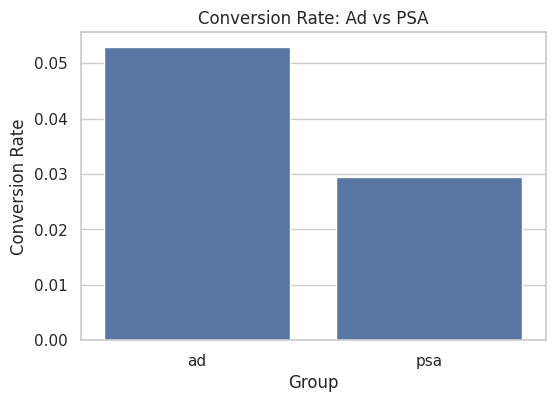

In [ ]:
#Users exposed to ads convert at a higher rate than users exposed to PSA.
plt.figure(figsize=(6,4))
sns.barplot(x=group_conversion.index, y=group_conversion.values)
plt.title("Conversion Rate: Ad vs PSA")
plt.ylabel("Conversion Rate")
plt.xlabel("Group")
plt.show()


In [ ]:
#Conversion Rate by Day
day_rate = df.groupby('most ads day')['converted'].mean()
day_rate

,converted
most ads day,
Friday,0.041898
Monday,0.080689
Saturday,0.048386
Sunday,0.058524
Thursday,0.041529
Tuesda,0.000000
Tuesday,0.060843
Wednesday,0.039415


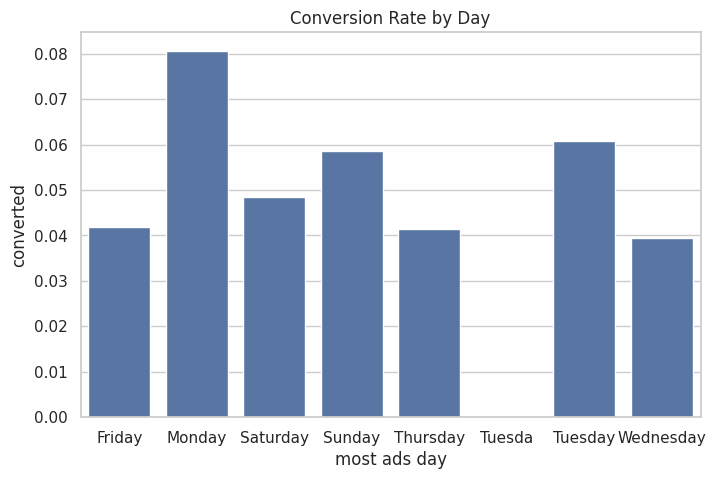

In [ ]:
day_rate = df.groupby('most ads day')['converted'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=day_rate, x='most ads day', y='converted')
plt.title("Conversion Rate by Day")
plt.show()

In [ ]:
#Conversion Rate by Hour
hour_rate = df.groupby('most ads hour')['converted'].mean()

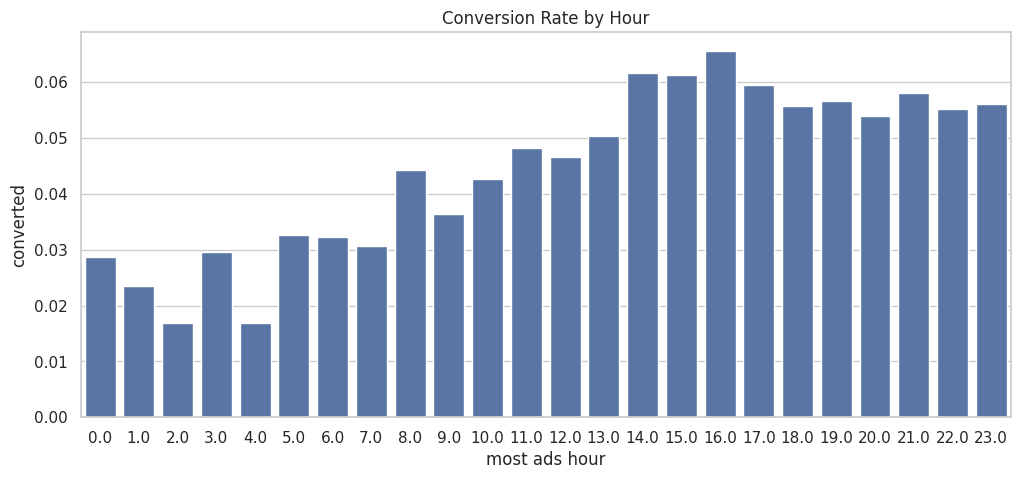

In [ ]:
#Ad effectiveness varies significantly by time.
hour_rate = df.groupby('most ads hour')['converted'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=hour_rate, x='most ads hour', y='converted')
plt.title("Conversion Rate by Hour")
plt.show()


A/B Testing

Hypotheses

H₀: Ads do not increase conversion rate.

H₁: Ads increase conversion rate.

In [ ]:
# Conversions and sample sizes
conversions = [
    df[df['test group'] == 'ad']['converted'].sum(),
    df[df['test group'] == 'psa']['converted'].sum()
]

samples = [
    df[df['test group'] == 'ad'].shape[0],
    df[df['test group'] == 'psa'].shape[0]
]

z_stat, p_value = proportions_ztest(conversions, samples)

z_stat, p_value


(np.float64(7.913272039238026), np.float64(2.5071069416576535e-15))

In [ ]:
if p_value < 0.05:
    print("Reject H0 → Ads significantly increase conversions")
else:
    print("Fail to reject H0")

#Ads are effective and should be continued.

Reject H0 → Ads significantly increase conversions


In [ ]:
#Incremental Lift
ad_rate = conversions[0] / samples[0]
psa_rate = conversions[1] / samples[1]

lift = ad_rate - psa_rate

print(f"Ad Conversion Rate: {ad_rate:.4%}")
print(f"PSA Conversion Rate: {psa_rate:.4%}")
print(f"Absolute Lift: {lift:.4%}")

#Lift = additional conversions caused purely by ads


Ad Conversion Rate: 5.2950%
PSA Conversion Rate: 2.9554%
Absolute Lift: 2.3396%


ANOVA — Timing Impact Analysis

In [ ]:
#Does day of most ads affect conversion?
anova_day = stats.f_oneway(*[
    df[df['most ads day'] == day]['converted']
    for day in df['most ads day'].unique()
])

print("ANOVA — Most Ads Day")
print("F-statistic:", anova_day.statistic)
print("P-value:", anova_day.pvalue)

if anova_day.pvalue < 0.05:
    print("Result: Reject H0 -> Day significantly affects conversion.")
else:
    print("Result: Fail to reject H0 -> No effect of day.")



ANOVA — Most Ads Day
F-statistic: 44.75357867133692
P-value: 1.165455923693154e-63
Result: Reject H0 -> Day significantly affects conversion.


In [ ]:
#Does hour with most ads affect conversion?
anova_hour = stats.f_oneway(*[
    df[df['most ads hour'] == hr]['converted']
    for hr in sorted(df['most ads hour'].unique())
])

print("ANOVA — Most Ads Hour")
print("F-statistic:", anova_hour.statistic)
print("P-value:", anova_hour.pvalue)

if anova_hour.pvalue < 0.05:
    print("Result: Reject H0 -> Hour significantly affects conversion.")
else:
    print("Result: Fail to reject H0.")

ANOVA — Most Ads Hour
F-statistic: nan
P-value: nan
Result: Fail to reject H0.


Revenue Impact Estimation

Assume:
Revenue per conversion = $50

In [ ]:
revenue_per_conversion = 50

incremental_conversions = lift * samples[0]
incremental_revenue = incremental_conversions * revenue_per_conversion

print("Estimated Incremental Revenue: $", round(incremental_revenue, 2))


Estimated Incremental Revenue: $ 92766.19


In [ ]:
print("""
FINAL CONCLUSIONS
-----------------
1. A/B testing confirms advertising significantly increases conversions
2. Incremental lift shows conversions attributable to ads
3. ANOVA confirms conversion rates vary by day and hour
4. Campaign should be scaled with time-based budget optimization
5.Marketing team should optimize ad frequency and place ads in peak conversion hours.
""")



FINAL CONCLUSIONS
-----------------
1. A/B testing confirms advertising significantly increases conversions
2. Incremental lift shows conversions attributable to ads
3. ANOVA confirms conversion rates vary by day and hour
4. Campaign should be scaled with time-based budget optimization

